# Importing Libraries

In [1]:
from diff_weighted_fields import Grid1D, GaussianFieldGenerator1D, Zeldovich1D, PowerSpectrum, MCMC, EPT1D
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax
from tqdm import tqdm
from mycolorpy import colorlist as mcp
from diff_weighted_fields.utils import covariance_to_correlation_batch, covariance_to_correlation
plt.style.use('thesis.mplstyle')
import numpy as np
from matplotlib import cm
from matplotlib.ticker import MultipleLocator

#grid setup
L = 4000
N = 512
dk     = 4    #units of kf
kmin   = 2    #units of kf
R_smooth = 1.2  #units of cell size
kmax   = 0.5  #units of kNyq

#define the field and gaussian generator
grid = Grid1D((N,), L, kmin=kmin, kmax = kmax, dk = dk, R_clip = R_smooth)

Using clipping smoothing with R_clip = 1.2 cells (physical = 9.375); k_smooth = 3.351e-01


In [2]:
print('Grid clip Properties:')
print(grid)

Grid clip Properties:
Using Clipping smoothing with R_clip = 1.2
kmin: 0.0031415926535897933
kmax: 0.20106192982974677
dk: 0.006283185307179587
N: 512
Shape: (512,)
L: 4000
Volume: 4000.0



Text(0, 0.5, 'P(k)')

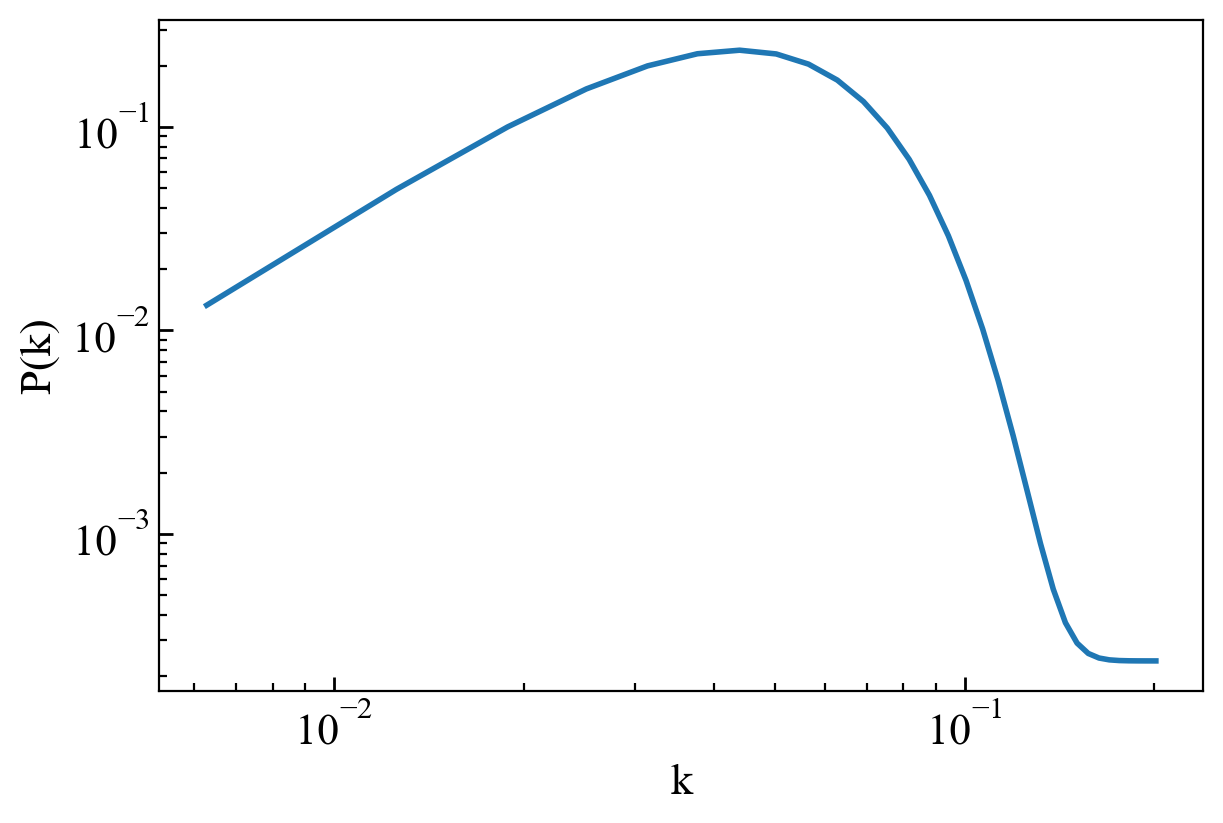

In [3]:
def PK(k,theta, threshold = 0.001):
    A,R,n = theta
    physical_R = R * grid.H[0]
    k_std = jnp.pi/physical_R
    _p = A*(k*R)**n*jnp.exp(-0.5*(k/k_std)**2)
    sig = jnp.max(_p)
    return _p + sig* threshold

A = 2.0
R_pk = 13. #units of cell size
n = 2.
theta = jnp.array([A, R_pk, n])

plt.figure()
plt.loglog(grid.k_ctrs, PK(grid.k_ctrs, theta), label='Power Spectrum')  
plt.xlabel('k') 
plt.ylabel('P(k)')

In [4]:
#white noise used to generate the field
keys = split(PRNGKey(2),300)
noise = jnp.array([grid.generate_hermitian_noise(x) for x in keys])

In [5]:
#gaussian and zeldovich field generators
gen = GaussianFieldGenerator1D(grid, PK)
EPT = EPT1D(gen)

In [6]:
def StandardDeviation_phi(theta,coeffs):
    stds = []
    for _noise in noise:
        f = EPT.make_realization(theta,_noise,coeffs = coeffs)
        stds.append(jnp.std(f.delta))
    return jnp.mean(jnp.array(stds))

In [100]:
def compute_cov(x):
    x = x - jnp.mean(x, axis=0)
    return (x.T @ x) / (x.shape[0] - 1)
compute_cov_batch = jax.vmap(compute_cov, in_axes=0)

def compute_inv_cov(x,
                    eps_reg: float = 1e-10,
                    eps_rank: float = 1e-10):
    
    n_mocks = x.shape[0]
    n_data = x.shape[1]
    cov = compute_cov(x)

    hartlap = (n_mocks - n_data - 2.0) / (n_mocks - 1.0)
    inv = jnp.linalg.inv(cov) * hartlap
    return inv

compute_inv_cov_batch = jax.vmap(compute_inv_cov, in_axes=0)

@jax.jit
def compute_pk_1T(theta,coeff,C):
    pk_batch = EPT.make_realization_batch(coeff,theta,C,noise)
    return pk_batch

jac_pk_ST = jax.jacfwd(compute_pk_1T, argnums=0)

@jax.jit
def compute_F_batch_1T(theta,coeff,C):
    P = compute_pk_1T(theta,coeff,C)
    inv_cov = compute_inv_cov_batch(P)
    J = jac_pk_ST(theta,coeff,C)
    J = jnp.mean(J, axis=1)
    F = jnp.einsum('nij, nip, njq->npq', inv_cov, J, J)
    return F

@jax.jit
def compute_gauss_entropy(theta,coeff,C):
    P = compute_pk_1T(theta,coeff,C)
    cov = compute_cov_batch(P)
    corr = covariance_to_correlation_batch(cov)
    gauss_ent = 0.5*jnp.log(jnp.linalg.det(corr))
    return gauss_ent

In [101]:
sigma_phi1 = StandardDeviation_phi(theta, coeffs=jnp.array([1,0,0,0,0,0,]))
sigma_phi2 = StandardDeviation_phi(theta, coeffs=jnp.array([0,1,0,0,0,0,]))
sigma_phi3 = StandardDeviation_phi(theta, coeffs=jnp.array([0,0,1,0,0,0,]))
sigma_lap1 = StandardDeviation_phi(theta, coeffs=jnp.array([0,0,0,1,0,0,]))
sigma_lap2 = StandardDeviation_phi(theta, coeffs=jnp.array([0,0,0,0,1,0,]))
sigma_inv_lap_phi1 = StandardDeviation_phi(theta, coeffs=jnp.array([0,0,0,0,0,1,]))

In [102]:
sigma_phi2/sigma_phi1**2

Array(1.38605149, dtype=float64)

In [106]:
gamma1 = 0
gamma2 = 0
gamma3 = 0
gamma_lap = 0
gamma_lap2 = 0
gamma_inv_lap_phi = 1

coeff = jnp.array([gamma1/sigma_phi1,
                   gamma2/sigma_phi2,
                   gamma3/sigma_phi3,
                   gamma_lap/sigma_lap1,
                   gamma_lap2/sigma_lap2,
                   gamma_inv_lap_phi/sigma_inv_lap_phi1])
SIGMA = StandardDeviation_phi(theta, coeffs=coeff)

In [107]:
SIGMA

Array(1., dtype=float64)

In [108]:
coeff_base = jnp.array([1,0,0,0,0,0])
C = jnp.array([[1,0,0]])

pk_base = jnp.mean(compute_pk_1T(theta, coeff_base, C),axis = 1)[0]
pk = jnp.mean(compute_pk_1T(theta, coeff, C),axis = 1)[0]

# Transforming non-Gaussian Fields

In [149]:
# Create a C mesh with logspaced values and ensure c_vec=0 is included
Nx = 100
c_vec_neg = -jnp.logspace(-3, jnp.log10(20), Nx // 2, endpoint=False)[::-1]
c_vec_pos = jnp.logspace(-3,  jnp.log10(20), Nx // 2, endpoint=True)
c_vec = jnp.concatenate([c_vec_neg, jnp.array([0.0]), c_vec_pos[:-1]])
zeroth_id = Nx//2

In [150]:
ones = jnp.ones_like(c_vec)
zeros = jnp.zeros_like(c_vec)
C = jnp.stack([ones, c_vec, zeros], axis=-1)

In [151]:
a_vec = jnp.linspace(-20,20,50)

batch_size = 100
steps = C.shape[0] // batch_size
_ = compute_F_batch_1T(theta,jnp.array([1,0,0,0,0,0]),C[0:batch_size]).block_until_ready()  

In [152]:
def compute_single_a(a1,a2,a3,a4,a5,a6):
    fisher = []
    #COEFF1 = jnp.array([a1/sigma_phi1,a2/sigma_phi2,a3/sigma_phi3,a4/sigma_lap1,a5/sigma_lap2,a6/sigma_inv_lap_phi1])
    COEFF1 = jnp.array([a1,a2,a3,a4,a5,a6])
    for i in tqdm(range(steps)):
        start = i * batch_size
        end = start + batch_size
        fisher.append(compute_F_batch_1T(theta, COEFF1, C[start:end]).block_until_ready())
    fisher = jnp.array(fisher)
    return jnp.array(fisher).reshape(Nx,3,3)

In [167]:
stacked_fisher = []
for this_a in a_vec:
    fisher = compute_single_a(1.0, this_a, -150, 0.,0.,0.)
    stacked_fisher.append(fisher)

stacked_fisher = jnp.array(stacked_fisher)
detF = jnp.linalg.det(stacked_fisher)
detF /= detF[:, 50][:, None]

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


In [168]:
Cmesh,gamma2 = jnp.meshgrid(c_vec,a_vec,indexing='ij')

/var/folders/f8/984tm4nj4h53x1yjrnpd76bw0000gn/T/ipykernel_19466/3665018891.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_above = cm.get_cmap('hsv')  # Colormap for levels above 1.0
/var/folders/f8/984tm4nj4h53x1yjrnpd76bw0000gn/T/ipykernel_19466/3665018891.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_below = cm.get_cmap('Greys')   # Colormap for levels below 1.0


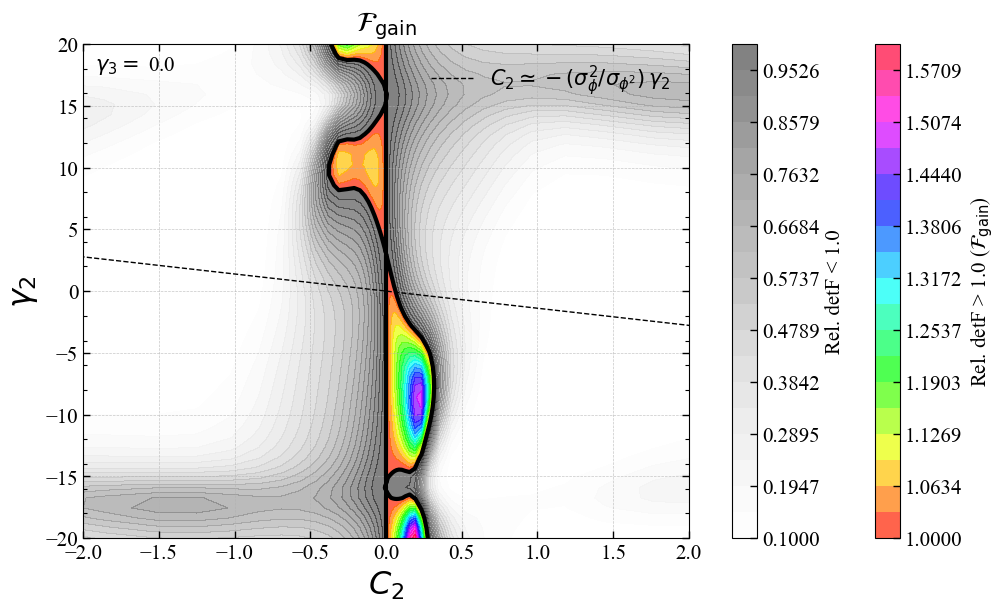

In [175]:
fontsize = 15  # Set the overall font size
alpha = float(sigma_phi2/(sigma_phi1**2) )  # ≈ slope factor

from matplotlib.colors import Normalize
from matplotlib import cm

Cmesh, gamma2 = jnp.meshgrid(c_vec, a_vec, indexing='ij')
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=100, constrained_layout=True)

# Define levels for above and below 1.0
levels_above = jnp.linspace(1.0, jnp.max(detF), 20)
levels_below = jnp.linspace(0.1, 1.0, 20)

# Create two colormaps
cmap_above = cm.get_cmap('hsv')  # Colormap for levels above 1.0
cmap_below = cm.get_cmap('Greys')   # Colormap for levels below 1.0

# Plot levels below 1.0
cf_below = ax.contourf(Cmesh, gamma2, detF.T, levels=levels_below, cmap=cmap_below, alpha=0.5)

# Plot levels above 1.0
cf_above = ax.contourf(Cmesh, gamma2, detF.T, levels=levels_above, cmap=cmap_above, alpha=0.7)

# Add colorbars for both colormaps
cbar_above = plt.colorbar(cf_above, ax=ax, label=r'Rel. detF > 1.0 ($\mathcal{F}_{\rm gain}$)')
cbar_above.ax.tick_params(labelsize=fontsize)  # Increase tick label size
cbar_above.set_label(r'Rel. detF > 1.0 ($\mathcal{F}_{\rm gain}$)', fontsize=fontsize)  # Increase caption size

cbar_below = plt.colorbar(cf_below, ax=ax, label='Rel. detF < 1.0', alpha=0.1)
cbar_below.ax.tick_params(labelsize=fontsize)  # Increase tick label size
cbar_below.set_label('Rel. detF < 1.0', fontsize=fontsize)  # Increase caption size

# Highlight the region where detF = 1
ax.contour(Cmesh, gamma2, detF.T, levels=[1], colors='black', linewidths=3, linestyles='-')

# Add the line y = -x
#ax.plot(c_vec, -2*c_vec, color='red', linestyle='--', linewidth=2, label=r'$y = -2*x$')
ax.plot(c_vec, -alpha*c_vec, linestyle='--', linewidth=1,
        color='k', label=r'$C_2 \simeq -(\sigma_\phi^2/\sigma_{\phi^2})\,\gamma_2$')

# Add labels and grid
ax.set_xlim((-2, 2))
ax.set_ylim((-20, 20))
ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=fontsize)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(2))

# Add axis labels and title
ax.set_xlabel(r'$C_2$', fontsize=fontsize + 8)
ax.set_ylabel(r'$\gamma_2$', fontsize=fontsize + 8)
ax.set_title(r'$\mathcal{F}_{\rm gain}$', fontsize=fontsize + 5, pad=10)

# Add annotation in the upper left
ax.annotate(rf"$\gamma_3 =$ 0.0", xy=(0.02, 0.98), xycoords='axes fraction',
            ha='left', va='top', fontsize=fontsize, color='black')

# Add legend
ax.legend(fontsize=fontsize)

# Adjust ticks and layout
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# Save the plot if needed
plt.savefig('detF_gamma2_gamma3_-150_C2.pdf', bbox_inches='tight')
plt.show()

# C2 C3

In [135]:
# 1) your original 1D c_vec of length Nx
Nx, Ny = 100, 100
norm_id = Nx//2
c_vec = jnp.concatenate([
    -jnp.logspace(-2, jnp.log10(4), Nx // 2, endpoint=False)[::-1],
     jnp.array([0.0]),
     jnp.logspace( -2, jnp.log10(4), Nx // 2, endpoint=True)[:-1]
])  # shape (Nx,)

# 2) if you want the same vector along y, just reuse c_vec (requires Ny == Nx).
#    Otherwise build a separate 'c_vec_y' of length Ny similarly.
c_vec_y = jnp.concatenate([
    -jnp.logspace(-2, jnp.log10(7), Ny // 2, endpoint=False)[::-1],
     jnp.array([0.0]),
     jnp.logspace( -2, jnp.log10(7), Ny // 2, endpoint=True)[:-1]
])  # shape (Ny,)

# 3) mesh them so C1[i,j] = c_vec[i], C2[i,j] = c_vec_y[j]
C1, C2 = jnp.meshgrid(c_vec, c_vec_y, indexing='ij')  # both shape (Nx,Ny)

# 4) C0 is all ones
C0 = jnp.ones_like(C1)                               # shape (Nx,Ny)

# 5) stack into (Nx,Ny,3) and then flatten to (Nx*Ny,3)
C_plane = jnp.stack([C0, C1, C2], axis=-1)           # (Nx,Ny,3)
C_flat  = C_plane.reshape(-1, 3)                     # (Nx*Ny,3)

In [136]:
batch_size = 50
steps = C_flat.shape[0] // batch_size
_ = compute_F_batch_1T(theta,jnp.array([1,0,0,0,0,0]),C_flat[0:batch_size]).block_until_ready()  

100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


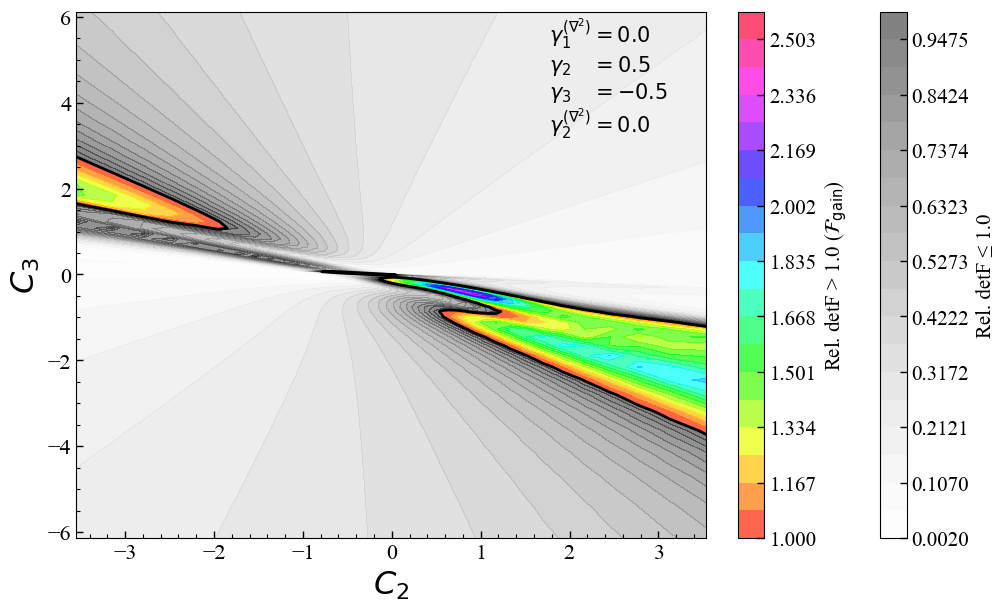

In [304]:
for v in [0.5]:
    GAMMA1 = 1.0
    GAMMA2 = v
    GAMMA3 = -v
    GAMMA_lap1 = 0.0
    GAMMA_lap2 = 0.0
    COEFF = jnp.array([GAMMA1/sigma_phi1,GAMMA2/sigma_phi2,GAMMA3/sigma_phi3,GAMMA_lap1/sigma_lap1,GAMMA_lap2/sigma_lap2,0])
    OMEGA = EPT.make_realization_batch_field(COEFF,theta,jnp.array([[1,0,0],[0,1,0],[0,0,1]]),noise)
    C1_norm, C2_norm, C3_norm = jnp.mean(jnp.std(OMEGA,axis = 1),1)
    C_norm = jnp.array([C1_norm, C2_norm, C3_norm])

    def compute_single(a1,a2,a3,a4,a5,a6):
        fisher = []
        COEFF1 = jnp.array([a1/sigma_phi1,a2/sigma_phi2,a3/sigma_phi3,a4/sigma_lap1,a5/sigma_lap2,a6/sigma_inv_lap_phi1])
        for i in tqdm(range(steps)):
            start = i * batch_size
            end = start + batch_size
            fisher.append(compute_F_batch_1T(theta, COEFF1, C_flat[start:end]).block_until_ready())
        fisher = jnp.array(fisher)
        return jnp.array(fisher).reshape(Nx,Ny,3,3)

    test = compute_single(GAMMA1, GAMMA2, GAMMA3, GAMMA_lap1,GAMMA_lap2,0)
    detF_test = jnp.linalg.det(test)
    norm = detF_test[norm_id,norm_id]
    rel_detF = detF_test / norm

    vmin, vmax = rel_detF.min(), rel_detF.max()
    fontsize = 15

    fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=100, constrained_layout=True)

    # ALWAYS do the below‐1 plotting
    levels_below = np.linspace(vmin, 1.0, 20)
    cf_below = ax.contourf(
        C1, C2, rel_detF,
        levels=levels_below,
        cmap=cm.Greys,
        alpha=0.5
    )
    cbar_b = plt.colorbar(cf_below, ax=ax, label='Rel. detF ≤ 1.0')
    cbar_b.ax.tick_params(labelsize=fontsize)
    cbar_b.set_label('Rel. detF ≤ 1.0', fontsize=fontsize)

    # ONLY do above‐1 if there’s something to show
    if vmax > 1.0 + 1e-8:        # tiny epsilon to avoid float issues
        levels_above = np.linspace(1.0, vmax, 20)
        cf_above = ax.contourf(
            C1, C2, rel_detF,
            levels=levels_above,
            cmap=cm.hsv,
            alpha=0.7
        )
        cbar_a = plt.colorbar(cf_above, ax=ax,
                            label=r'Rel. detF > 1.0 ($\mathcal{F}_{\rm gain}$)')
        cbar_a.ax.tick_params(labelsize=fontsize)
        cbar_a.set_label(r'Rel. detF > 1.0 ($\mathcal{F}_{\rm gain}$)', fontsize=fontsize)

    # always draw the 1.0 contour
    ax.contour(
        C1, C2, rel_detF,
        levels=[1.0],
        colors='black',
        linewidths=2
    )
    #ax.set_xlim((-0.7,0.7))
    #ax.set_ylim((-0.7,0.7))
    # styling
    #ax.set_xlim(-0.25, 0.1)
    #ax.set_ylim(-0.01, 0.1)
    #ax.grid(True, linestyle='--', alpha=0.7)
    #
    #ax.yaxis.set_major_locator(MultipleLocator(0.025))  # Adjust major ticks to reduce the number of points
    #ax.xaxis.set_major_locator(MultipleLocator(0.05))  # Adjust major ticks to reduce the number of points

    #ax.xaxis.set_minor_locator(MultipleLocator(0.01))  # Keep minor ticks for finer grid
    #ax.yaxis.set_minor_locator(MultipleLocator(0.01))  # Keep minor ticks for finer grid
    #ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=fontsize)

    ax.annotate(rf"$\gamma_2 \quad = {GAMMA2}$",xy=(0.75, 0.92) , xycoords='axes fraction',
                ha='left', va='top', fontsize=fontsize, color='black')

    ax.annotate(rf"$\gamma_3 \quad = {GAMMA3}$",xy=(0.75, 0.87) , xycoords='axes fraction',
                ha='left', va='top', fontsize=fontsize, color='black')
    ax.annotate(rf"$\gamma_1^{{(\nabla^2)}} = {GAMMA_lap1}$", xy=(0.75, 0.99), xycoords='axes fraction',
                ha='left', va='top', fontsize=fontsize, color='black')
    ax.annotate(rf"$\gamma_2^{{(\nabla^2)}} = {GAMMA_lap2}$", xy=(0.75, 0.82), xycoords='axes fraction',
                ha='left', va='top', fontsize=fontsize, color='black')
    ax.set_xlabel(r'$C_2$', fontsize=fontsize + 8)
    ax.set_ylabel(r'$C_3$', fontsize=fontsize + 8)
    #plt.savefig('detF_C2_C3_GAMMA1_{}_GAMMA2_{:.2f}_GAMMA3_{:.2f}_GAMMA_lap1_{:.2f}_GAMMA_lap2_{:.2f}.pdf'.format(GAMMA1, GAMMA2, GAMMA3, GAMMA_lap1,GAMMA_lap2), bbox_inches='tight')

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x30a8acd90>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x30c160310>)

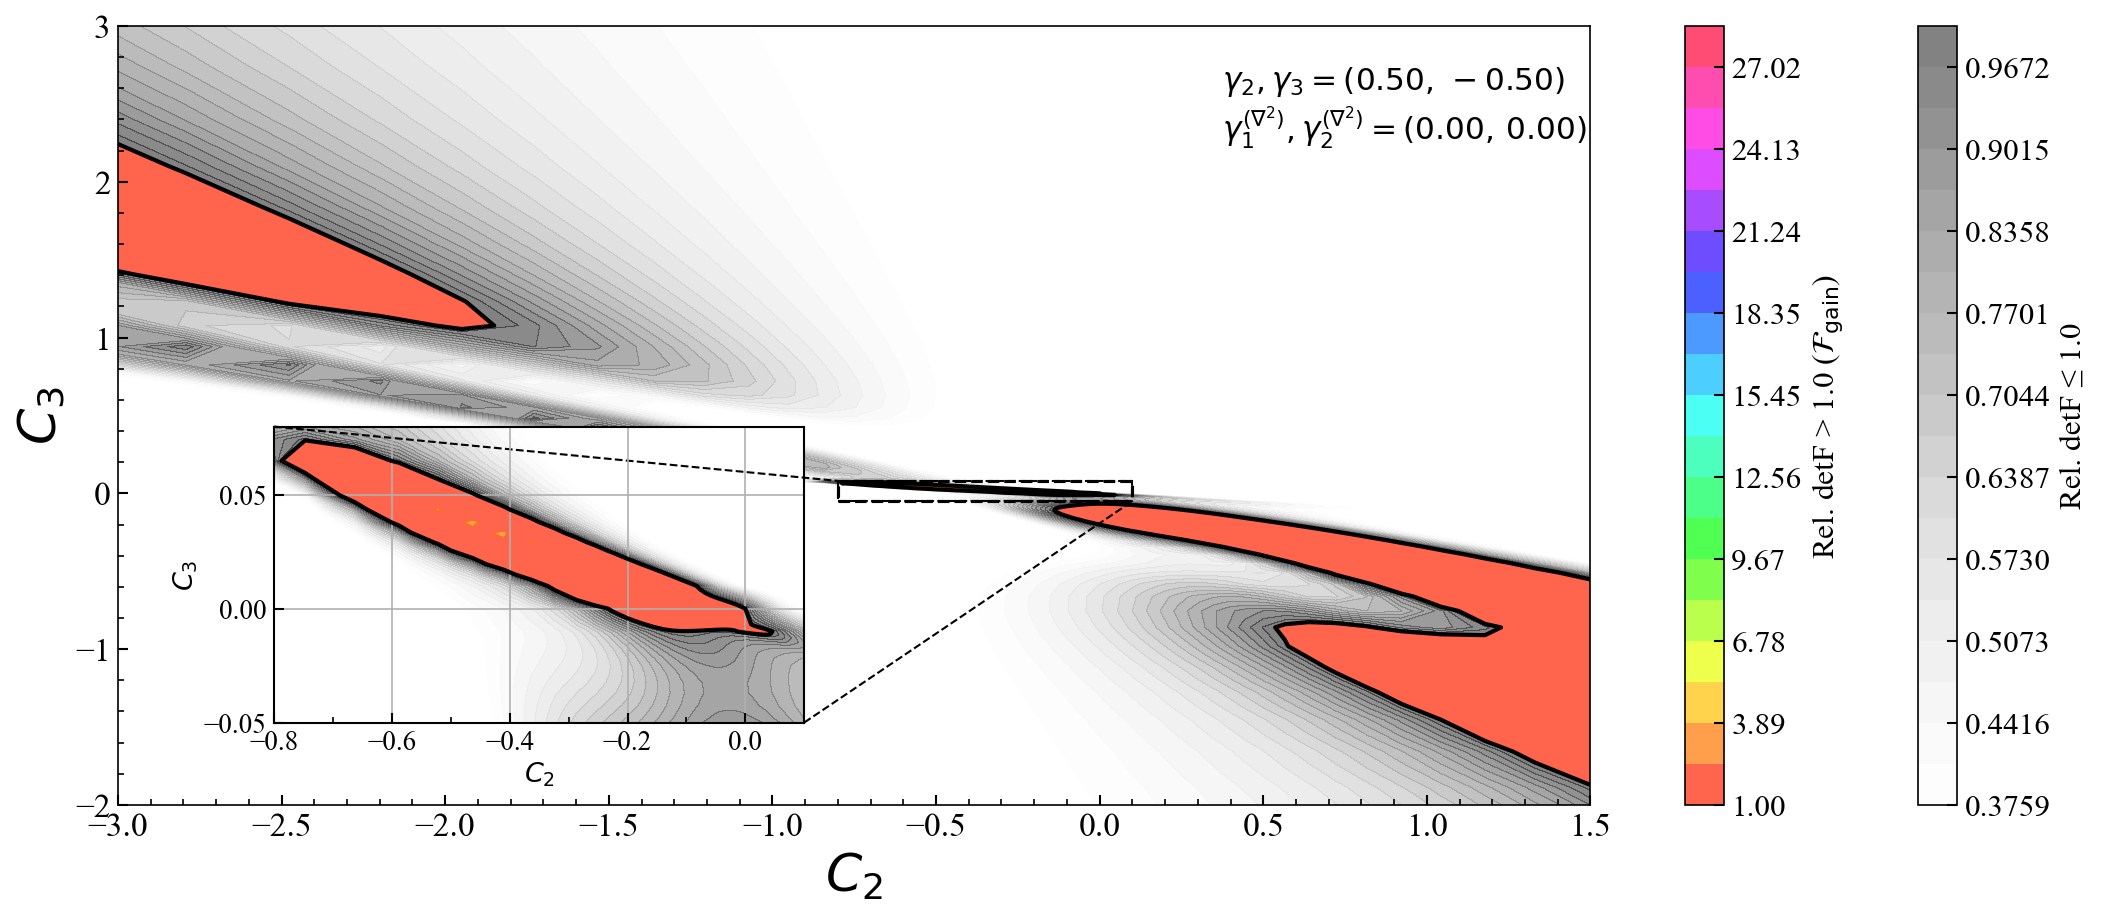

In [303]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


fig, ax = plt.subplots(1, 1, figsize=(14, 6), dpi=150, constrained_layout=True)
fontsize = 15
# BELOW-1 fill
levels_below = np.linspace(vmin, 1.0, 20)
cf_below = ax.contourf(
    C1, C2, rel_detF,
    levels=levels_below,
    cmap=cm.Greys,
    alpha=0.5
)
cbar_b = plt.colorbar(cf_below, ax=ax, label='Rel. detF ≤ 1.0')
cbar_b.ax.tick_params(labelsize=fontsize)
cbar_b.set_label('Rel. detF ≤ 1.0', fontsize=fontsize)

# ABOVE-1 fill (if any)
if vmax > 1.0 + 1e-8:
    levels_above = np.linspace(1.0, vmax, 20)
    cf_above = ax.contourf(
        C1, C2, rel_detF,
        levels=levels_above,
        cmap=cm.hsv,
        alpha=0.7
    )
    cbar_a = plt.colorbar(cf_above, ax=ax,
                          label=r'Rel. detF > 1.0 ($\mathcal{F}_{\rm gain}$)')
    cbar_a.ax.tick_params(labelsize=fontsize)
    cbar_a.set_label(r'Rel. detF > 1.0 ($\mathcal{F}_{\rm gain}$)', fontsize=fontsize)

# Black contour at exactly 1.0
ax.contour(
    C1, C2, rel_detF,
    levels=[1.0],
    colors='black',
    linewidths=2
)
# Annotations
# top‐row: γ₂ and γ₃ together
ax.annotate(
    rf"$\gamma_2, \gamma_3 = ({GAMMA2:.2f},\,{GAMMA3:.2f})$",
    xy=(0.75, 0.95), xycoords='axes fraction',
    ha='left', va='top',
    fontsize=fontsize, color='black'
)

# bottom‐row: ∇²‐coeffs together
ax.annotate(
    rf"$\gamma_1^{{(\nabla^2)}}, \gamma_2^{{(\nabla^2)}} = ({GAMMA_lap1:.2f},\,{GAMMA_lap2:.2f})$",
    xy=(0.75, 0.90), xycoords='axes fraction',
    ha='left', va='top',
    fontsize=fontsize, color='black'
)

ax.set_xlabel(r'$C_2$', fontsize=fontsize + 10)
ax.set_ylabel(r'$C_3$', fontsize=fontsize + 10)
ax.set_ylim((-2,3))
ax.set_xlim((-3,1.5))
# --- now add the zoom inset ---

# 1) define zoom region in data coordinates
x1, x2 = -0.8, 0.1
y1, y2 = -0.05, 0.08

# 2) draw dashed rectangle on main axes
rect = Rectangle((x1, y1),
                 x2 - x1,
                 y2 - y1,
                 linewidth=1.5,
                 edgecolor='black',
                 facecolor='none',
                 linestyle='--')
ax.add_patch(rect)

# 3) create an inset axes in lower-left corner
axins = inset_axes(ax,
                   width="40%",   # size of inset relative to parent
                   height="40%",
                    bbox_to_anchor=(-0.4, -0.4, 0.9, 0.95),
                   bbox_transform=ax.transAxes,
                   borderpad=2)

# 4) re-plot the SAME data inside inset
#    below-1
axins.contourf(
    C1, C2, rel_detF,
    levels=levels_below,
    cmap=cm.Greys,
    alpha=0.5
)
plt.setp(axins.spines.values(), color='black', linewidth=1)
axins.grid()
#    above-1
if vmax > 1.0 + 1e-8:
    axins.contourf(
        C1, C2, rel_detF,
        levels=levels_above,
        cmap=cm.hsv,
        alpha=0.7
    )
#    1.0 contour
axins.contour(
    C1, C2, rel_detF,
    levels=[1.0],
    colors='black',
    linewidths=2
)

# 5) set inset limits & turn ticks _on_ again
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# major and minor locators on the inset
axins.xaxis.set_major_locator(MultipleLocator(0.2))
axins.yaxis.set_major_locator(MultipleLocator(0.05))

axins.xaxis.set_minor_locator(MultipleLocator(0.1))
axins.yaxis.set_minor_locator(MultipleLocator(0.1))

# tick parameters: inward ticks, smaller font
axins.tick_params(
    axis='both', which='major',
    direction='in', length=5, width=1,
    labelsize=fontsize - 2
)
axins.tick_params(
    axis='both', which='minor',
    direction='in', length=3, width=0.8
)

# 6) add axis labels to inset
axins.set_xlabel(r'$C_2$', fontsize=fontsize - 2, labelpad=2)
axins.set_ylabel(r'$C_3$', fontsize=fontsize - 2, labelpad=2)

# 7) draw connector “flanges”
mark_inset(ax, axins,
           loc1=2, loc2=4,  # corners to connect
           fc="none", ec="black", linewidth=1.0, linestyle='--')

#plt.savefig('detF_C2_C3_GAMMA1_{}_GAMMA2_{:.2f}_GAMMA3_{:.2f}_GAMMA_lap1_{:.2f}_GAMMA_lap2_{:.2f}_zoom.pdf'.format(GAMMA1, GAMMA2, GAMMA3, GAMMA_lap1,GAMMA_lap2), bbox_inches='tight')
#plt.show()

In [267]:
pk = compute_pk_1T(theta, COEFF, jnp.array([[1,0,0]])).block_until_ready()
pk0 = compute_pk_1T(theta, jnp.array([1/sigma_phi1,0,0,0,0,0]), jnp.array([[1,0,0]])).block_until_ready()
COV = compute_cov_batch(pk)
COV0 = compute_cov_batch(pk0)

pk_mean = jnp.mean(pk, axis=1)
pk0_mean = jnp.mean(pk0, axis=1)

CORR = covariance_to_correlation_batch(COV)
CORR0 = covariance_to_correlation_batch(COV0)

batch_size = 50
steps = C_flat.shape[0] // batch_size
_ = compute_gauss_entropy(theta,jnp.array([1,0,0,0,0,0]),C_flat[0:batch_size]).block_until_ready()  

entropy = []
for i in tqdm(range(steps)):
    start = i * batch_size
    end = start + batch_size
    entropy.append(compute_gauss_entropy(theta, COEFF, C_flat[start:end]).block_until_ready())

100%|██████████| 200/200 [00:37<00:00,  5.30it/s]


NameError: name 'fisher' is not defined

In [279]:
entropy = jnp.array(entropy)
entropy = jnp.array(entropy).reshape(Nx,Ny)
entropy_norm = entropy / entropy[norm_id,norm_id]

In [286]:
entropy

Array([[-129.26941714, -128.61066645, -127.87492436, ..., -141.86532982,
        -140.88797596, -140.03744355],
       [-129.95231877, -129.37423475, -128.72631423, ..., -140.69453567,
        -139.87541953, -139.16207223],
       [-130.57064948, -130.06755553, -129.50183186, ..., -139.67577347,
        -138.99358327, -138.39868414],
       ...,
       [-142.01728623, -143.22375624, -144.64166687, ..., -126.32833414,
        -127.22880359, -128.0384443 ],
       [-142.88553903, -144.24245488, -145.84010899, ..., -125.61814479,
        -126.58802322, -127.4623093 ],
       [-143.88554904, -145.41742151, -147.22304858, ..., -124.8350621 ,
        -125.87948973, -126.82365056]], dtype=float64)

In [295]:
levels = np.linspace(0, 1, 20)

(-3.0, 1.5)

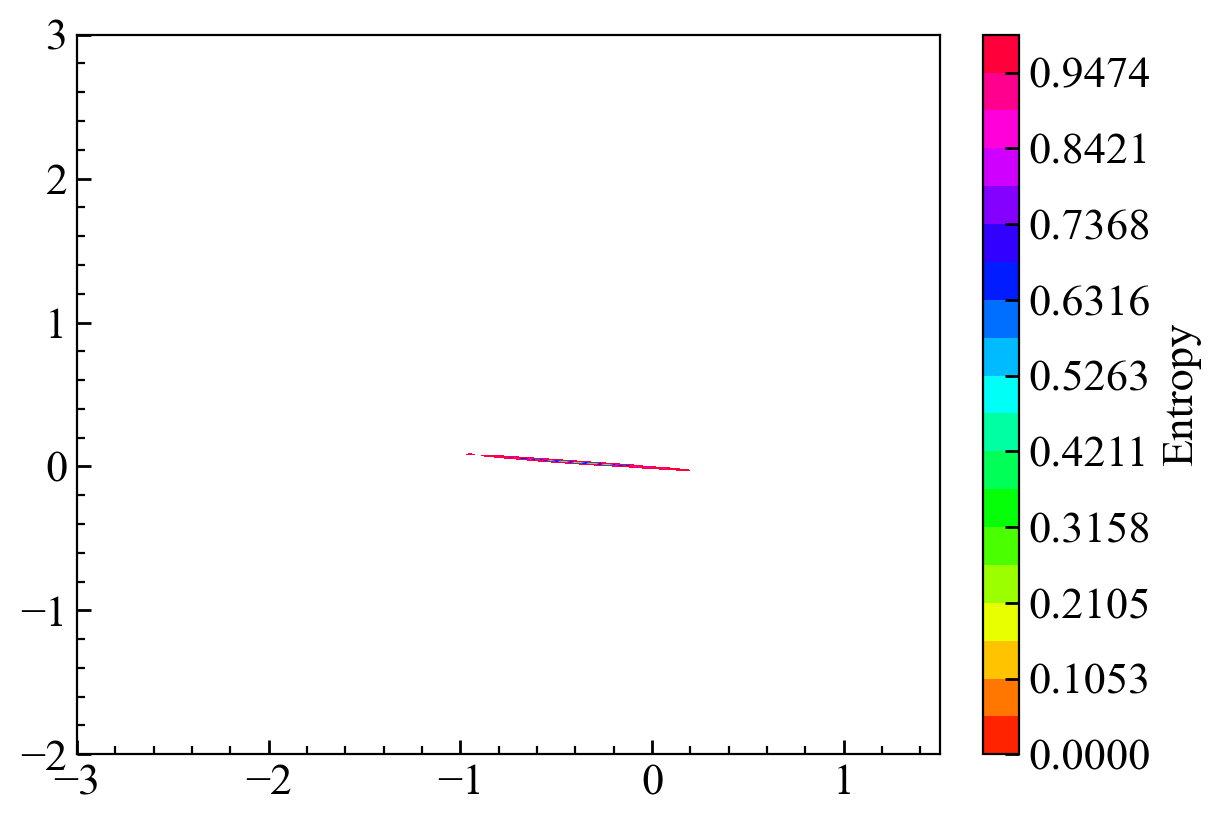

In [298]:
plt.contourf(C1,C2,entropy_norm,cmap = 'hsv', alpha = 1, levels = levels)
plt.colorbar(label='Entropy', alpha=0.5)
plt.ylim((-2,3))
plt.xlim((-3,1.5))

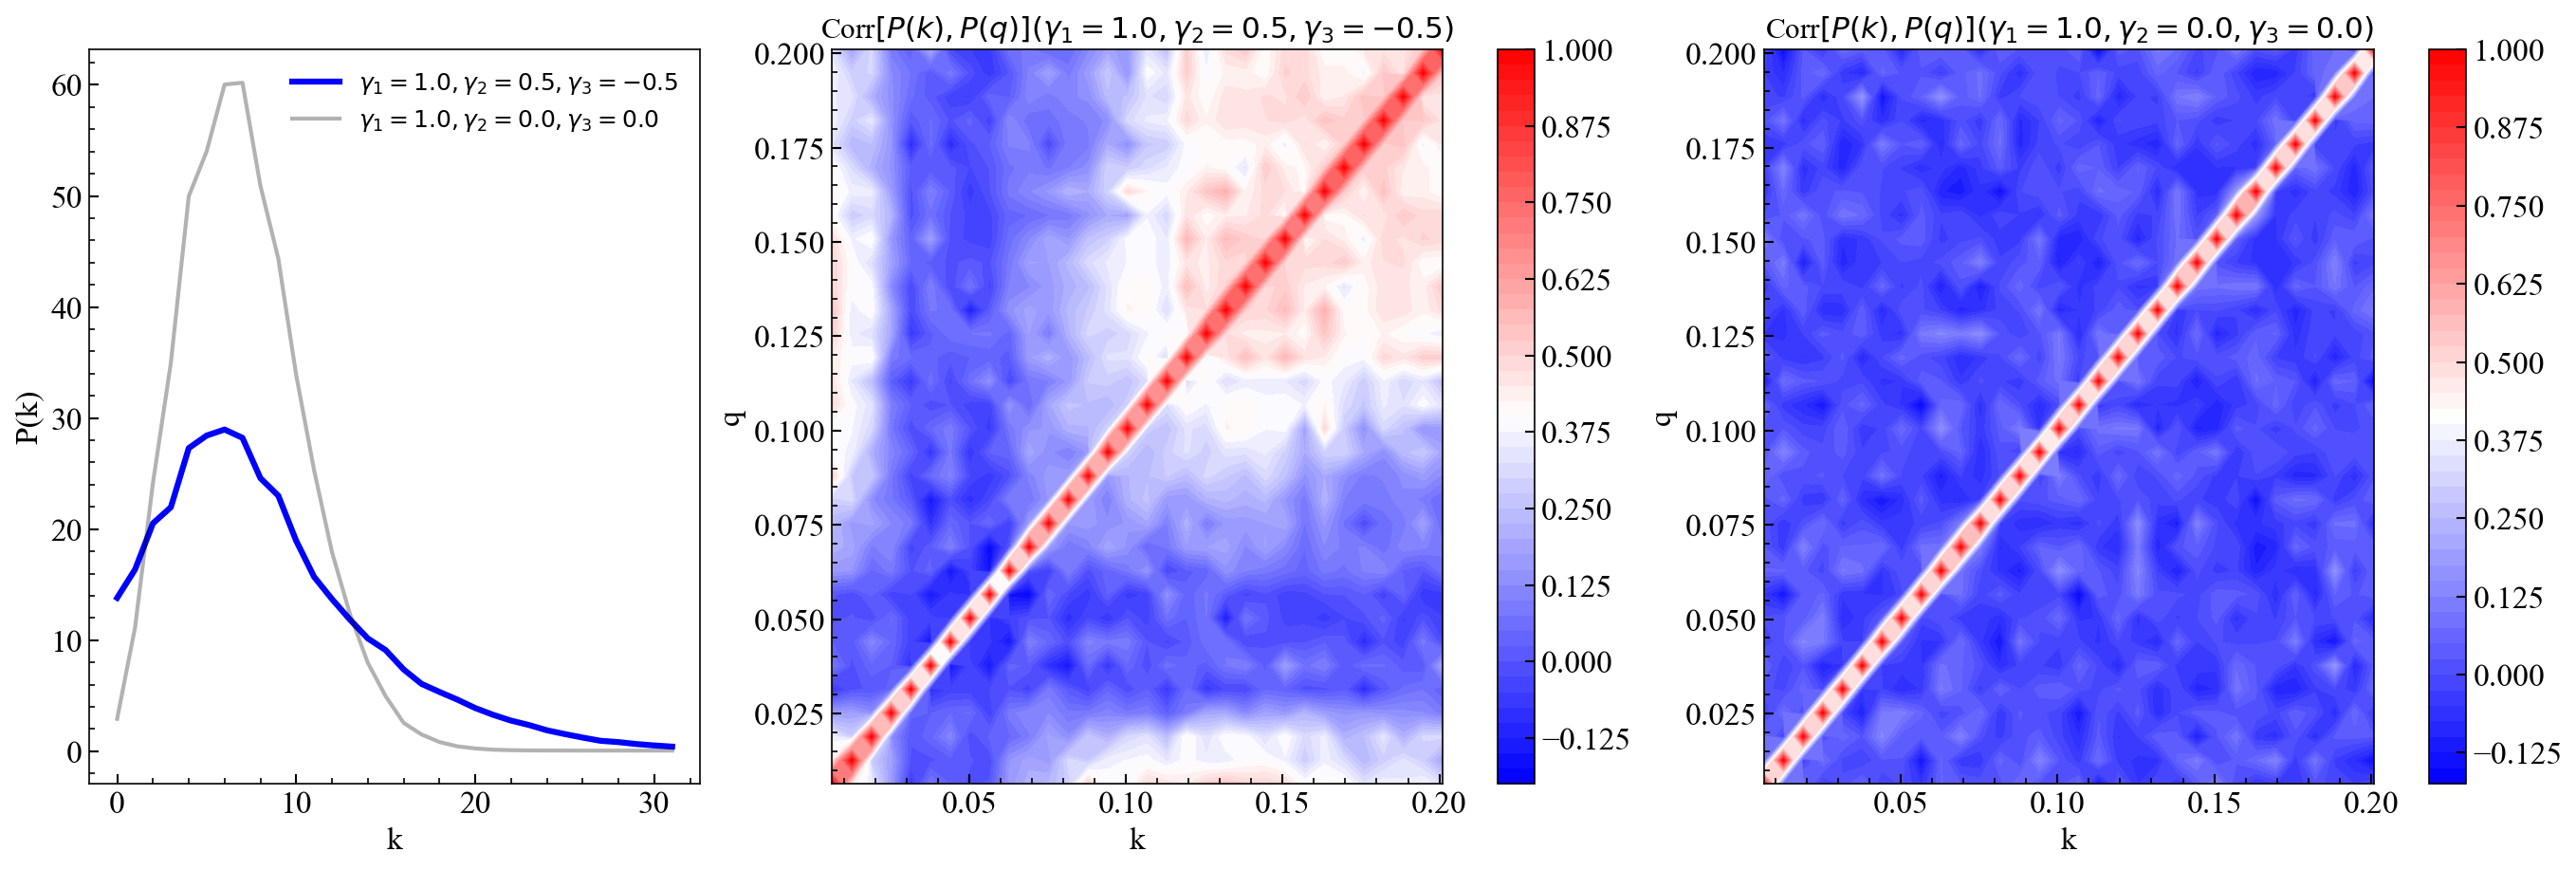

In [264]:
fig, ax = plt.subplots(1,3, figsize = (18,6), dpi = 150, constrained_layout=True)
ax[0].plot(pk_mean.T, label = r'$\gamma_1 = {},\gamma_2 = {}, \gamma_3 = {}$'.format(GAMMA1, GAMMA2,GAMMA3), color = 'blue', alpha = 1, ls = '-', lw = 3)
ax[0].plot(pk0_mean.T, color = 'black', alpha = 0.3, ls = '-',label = r'$\gamma_1 = 1.0,\gamma_2 = 0.0, \gamma_3 = 0.0$')
ax[0].set_xlabel('k')
ax[0].set_ylabel('P(k)')
ax[0].legend()

# Adjust the contourf plots for correlation matrices
k_ctrs = grid.k_ctrs  # Use the grid's k_ctrs for axis labels

#
im1 = ax[1].contourf(k_ctrs, k_ctrs, CORR[0], levels=50, cmap='bwr')
ax[1].set_xlabel('k')
ax[1].set_ylabel('q')
ax[1].set_title(r'Corr$[P(k),P(q)] (\gamma_1 = {},\gamma_2 = {}, \gamma_3 = {})$'.format(GAMMA1, GAMMA2, GAMMA3),fontsize=15)
fig.colorbar(im1, ax=ax[1], orientation='vertical')

# Plot CORR0
im2 = ax[2].contourf(k_ctrs, k_ctrs, CORR0[0], levels=50, cmap='bwr')
ax[2].set_xlabel('k')
ax[2].set_ylabel('q')
ax[2].set_title(r'Corr$[P(k),P(q)] (\gamma_1 = 1.0,\gamma_2 = 0.0, \gamma_3 = 0.0)$'.format(GAMMA1, GAMMA2, GAMMA3),fontsize=15)
fig.colorbar(im2, ax=ax[2], orientation='vertical')

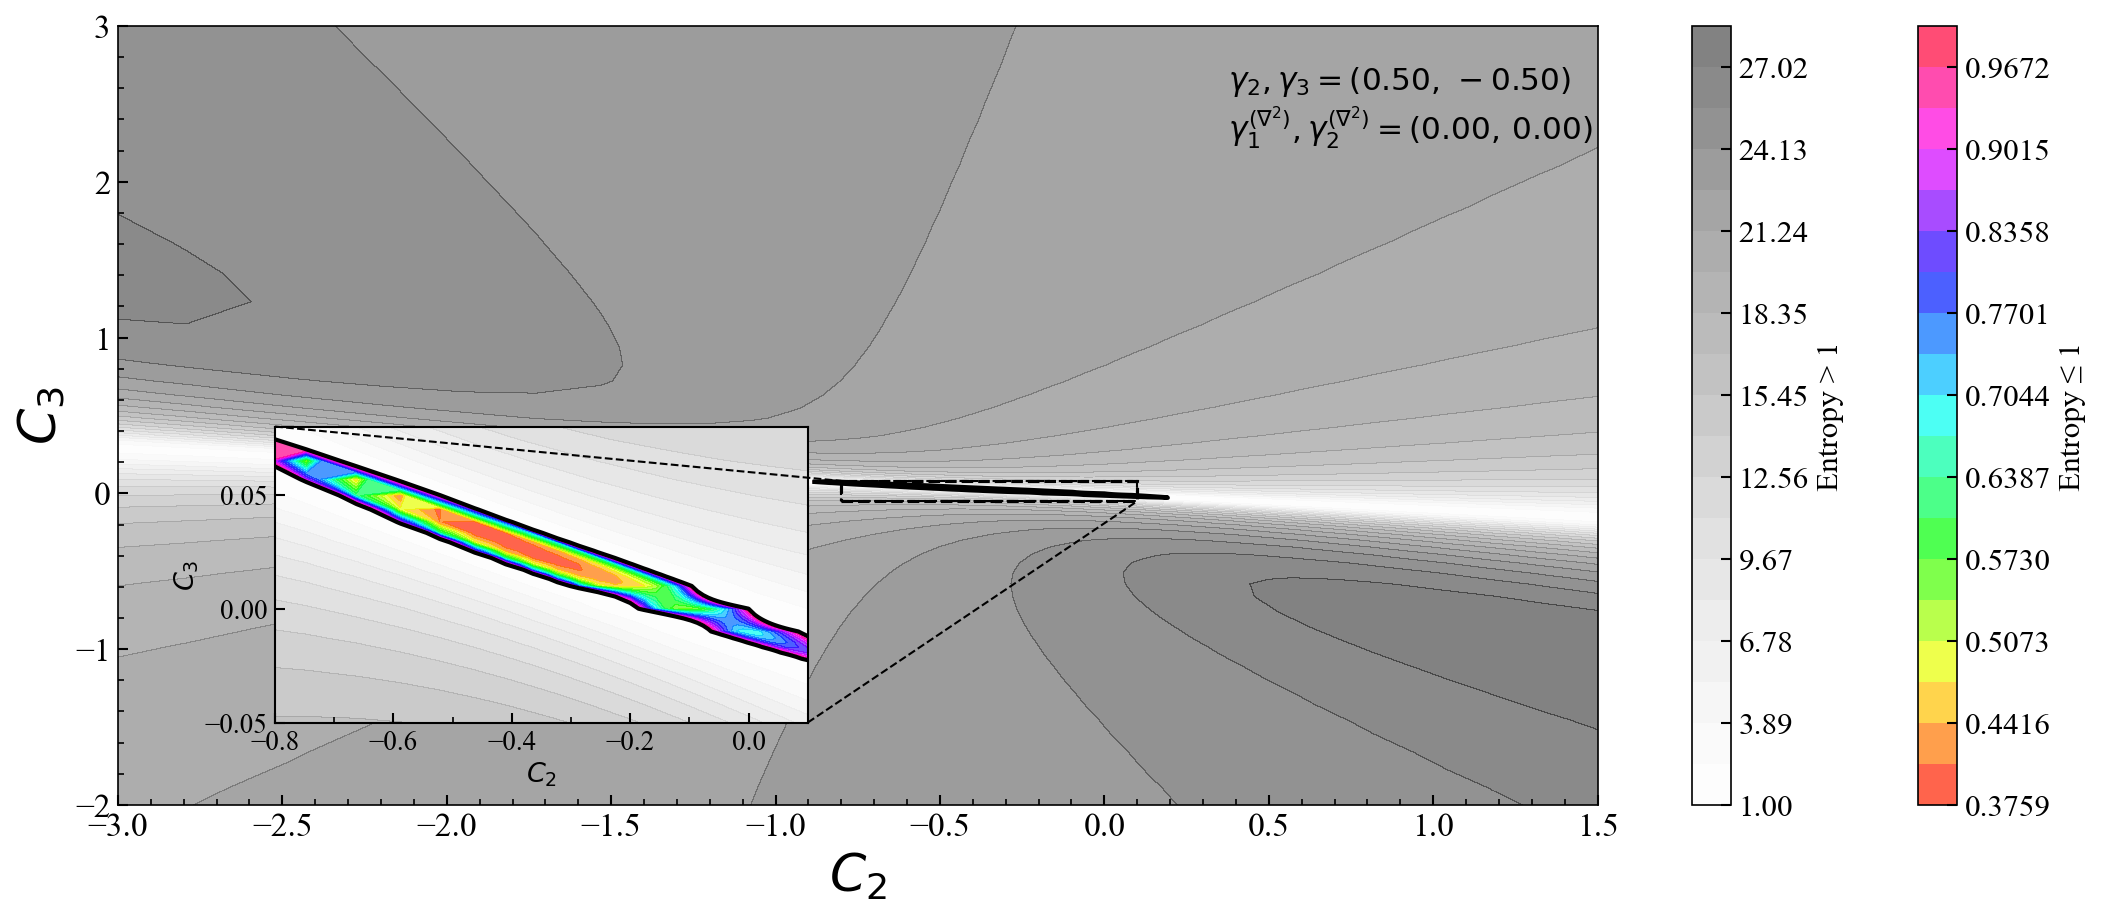

In [302]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# — assume entropy_norm, C1, C2, fontsize, GAMMA2, GAMMA3, GAMMA_lap1, GAMMA_lap2 are defined —
vmin, vmax = entropy_norm.min(), entropy_norm.max()

fig, ax = plt.subplots(1, 1, figsize=(14, 6), dpi=150, constrained_layout=True)

# 1) colored region [0,1]
levels_col = np.linspace(vmin, 1.0, 20)
cf_col = ax.contourf(
    C1, C2, entropy_norm,
    levels=levels_col,
    cmap=cm.hsv,
    alpha=0.7
)
cbar_col = plt.colorbar(cf_col, ax=ax, label='Entropy ≤ 1')
cbar_col.ax.tick_params(labelsize=fontsize)
cbar_col.set_label('Entropy ≤ 1', fontsize=fontsize)

# 2) gray region [1, vmax] (if any)
if vmax > 1.0 + 1e-8:
    levels_gray = np.linspace(1.0, vmax, 20)
    cf_gray = ax.contourf(
        C1, C2, entropy_norm,
        levels=levels_gray,
        cmap=cm.Greys,
        alpha=0.5
    )
    cbar_gray = plt.colorbar(cf_gray, ax=ax, label='Entropy > 1')
    cbar_gray.ax.tick_params(labelsize=fontsize)
    cbar_gray.set_label('Entropy > 1', fontsize=fontsize)

# 3) black contour at exactly 1.0
ax.contour(
    C1, C2, entropy_norm,
    levels=[1.0],
    colors='black',
    linewidths=2
)

# 4) annotations (unchanged)
ax.annotate(
    rf"$\gamma_2, \gamma_3 = ({GAMMA2:.2f},\,{GAMMA3:.2f})$",
    xy=(0.75, 0.95), xycoords='axes fraction',
    ha='left', va='top',
    fontsize=fontsize, color='black'
)
ax.annotate(
    rf"$\gamma_1^{{(\nabla^2)}}, \gamma_2^{{(\nabla^2)}} = ({GAMMA_lap1:.2f},\,{GAMMA_lap2:.2f})$",
    xy=(0.75, 0.90), xycoords='axes fraction',
    ha='left', va='top',
    fontsize=fontsize, color='black'
)

# 5) axes labels & limits (same as before)
ax.set_xlabel(r'$C_2$', fontsize=fontsize + 10)
ax.set_ylabel(r'$C_3$', fontsize=fontsize + 10)
ax.set_xlim(-3, 1.5)
ax.set_ylim(-2, 3)

# — now the zoomed inset exactly as before —

# define zoom window
x1, x2 = -0.8, 0.1
y1, y2 = -0.05, 0.08

# draw dashed rectangle on main axes
rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                 linewidth=1.5, edgecolor='black',
                 facecolor='none', linestyle='--')
ax.add_patch(rect)

# create inset axes
axins = inset_axes(ax,
                   width="40%", height="40%",
                   bbox_to_anchor=(-0.4, -0.4, 0.9, 0.95),
                   bbox_transform=ax.transAxes,
                   borderpad=2)

# re-plot inside inset
axins.contourf(C1, C2, entropy_norm, levels=levels_col, cmap=cm.hsv, alpha=0.7)
if vmax > 1.0 + 1e-8:
    axins.contourf(C1, C2, entropy_norm, levels=levels_gray, cmap=cm.Greys, alpha=0.5)
axins.contour(C1, C2, entropy_norm, levels=[1.0], colors='black', linewidths=2)

# add a solid frame
plt.setp(axins.spines.values(), color='black', linewidth=1)

# inset ticks & labels
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.xaxis.set_major_locator(MultipleLocator(0.2))
axins.yaxis.set_major_locator(MultipleLocator(0.05))
axins.xaxis.set_minor_locator(MultipleLocator(0.1))
axins.yaxis.set_minor_locator(MultipleLocator(0.1))
axins.tick_params(axis='both', which='major',
                  direction='in', length=5, width=1, labelsize=fontsize - 2)
axins.tick_params(axis='both', which='minor',
                  direction='in', length=3, width=0.8)
axins.set_xlabel(r'$C_2$', fontsize=fontsize - 2, labelpad=2)
axins.set_ylabel(r'$C_3$', fontsize=fontsize - 2, labelpad=2)

# connector “flanges”
mark_inset(ax, axins,
           loc1=2, loc2=4,
           fc="none", ec="black",
           linewidth=1.0, linestyle='--')

plt.savefig(
    'entropy_zoom_C2_{:.2f}_C3_{:.2f}.pdf'.format(x1, y2),
    bbox_inches='tight')
plt.savefig('entropy_C2_C3_GAMMA1_{}_GAMMA2_{:.2f}_GAMMA3_{:.2f}_GAMMA_lap1_{:.2f}_GAMMA_lap2_{:.2f}.pdf'.format(GAMMA1, GAMMA2, GAMMA3, GAMMA_lap1,GAMMA_lap2), bbox_inches='tight')
plt.show()